# GZK horizon visualisation

Assuming the continuous loss approximation for UHE proton propagation and typical detection uncertainties described in the paper, we can try to visualise what this means. We have a kind of *effective GZK horizon* for each particle, depending on its energy and the detection uncertainties. See Section 2.6 for details. We want to be able to plot the following:

$$
P(x, z | E, \omega, \rm{detected}),
$$
i.e. where the UHECR could have come from if we detect it with energy $E$ and direction $\omega$.
<br>
<br>
*This code was used to make Figures 4 and 5 in Capel & Mortlock (2019).*

In [3]:
import numpy as np
import h5py
from scipy import interpolate
import stan_utility

from fancy.propagation.energy_loss import get_Eth_src
from fancy.plotting.HPD_regions import grid_HPD_contours
from horizon_visualisation import P_x_z

In [4]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import seaborn as sns 
from fancy.plotting.colours import darkblue, midblue, lightblue, purple, lightpurple
from fancy.plotting.mpl_style import config_mplstyle
config_mplstyle()
plt.style.use(['minimalist']) # to match paper style

## Calculation

If we **ignore detection uncertainties**, it is possible to find an analytical expression for the above probability (see Equation 13). We plot this here by interpolating over a precomputed grid of values. 

### Precomputing $E_\rm{src}$ and $E_\rm{arr}$
These cells show how the files in `output/` have been computed. These computations can be re-run, but the output files are also provided with this code, so it is possible to skip ahead to the next subsection. 

In [3]:
# Select representative energies
selected_E = [50, 70] # EeV

# Precompute the equivalent source energies 
# for a range of propagation distances
# (this takes a while... ~10 min)
D = np.linspace(0, 500, 100) # Mpc
Esrc = [get_Eth_src(E, D) for E in selected_E] # EeV

# Write to a file to save time in future 
with h5py.File('output/precomp_Esrc.h5', 'w') as f:
    f.create_dataset('selected_E', data = selected_E)
    f.create_dataset('Esrc', data = Esrc)
    f.create_dataset('D', data = D)

In [ ]:
# We also want to calculate the arrival energies 
# for a range of source energies and distances.
# This is done with an MPI script on XX cores.
# ! mpirun -n XX python precomp_Earr.py

### Read precomputed values

In [5]:
with h5py.File('output/precomp_Esrc.h5', 'r') as f:
    D = f['D'][()]
    Esrc = f['Esrc'][()]
    
with h5py.File('output/precomp_Earr.h5', 'r') as f:
    Earr_grid = f['Earr_grid'][()]
    D_grid = f['D_grid'][()]
    E_grid = f['E_grid'][()]

### Figure 4 (upper panel)

For calculation, see `horizon_visualisation.py`.

In [6]:
# Set parameters
alpha = 2
B = 1 # nG

# Unpack for readability 
Esrc_50, Esrc_70 = Esrc

In [7]:
# Calculate P(x, z | E omega) on a meshgrid of x, z
# Takes ~ 10s
xl = np.linspace(0, 100, 300) # Mpc
zl = np.linspace(0, 400, 300) # Mpc
z, x = np.meshgrid(zl, xl)

P_x_z_50 = P_x_z(z, x, Esrc_50, D_grid, E_grid, Earr_grid, B, alpha)
P_x_z_70 = P_x_z(z, x, Esrc_70, D_grid, E_grid, Earr_grid, B, alpha)

In [8]:
# Get HPD contours or tail regions to show shape
levels = [0.99999, 0.99995, 0.9999, 0.999]
l50 = grid_HPD_contours(np.nan_to_num(P_x_z_50), levels)
levels = [0.99997, 0.9999, .9995, 0.999]
l70 = grid_HPD_contours(np.nan_to_num(P_x_z_70), levels)

# Prepare legend
legend_elements = [Line2D([0], [0], color = lightpurple, linestyle = ':', 
                          label = '$E = 50$ EeV', linewidth = 1.5), 
                  Line2D([0], [0], color = purple, label = '$E = 70$ EeV', 
                         linewidth = 1.5)]

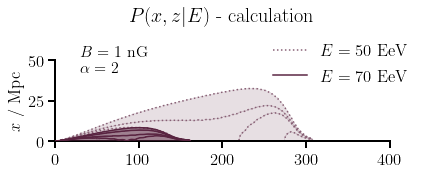

In [9]:
# Plot 
fig, ax = plt.subplots()
fig.set_size_inches((6, 0.25 * 6)) # hold aspect ratio

# Contour plots
ax.contour(zl, xl, P_x_z_70, l70, colors = purple, linewidths = 1.5, zorder = 3)
ax.contour(zl, xl, P_x_z_50, l50, colors = lightpurple, 
           linewidths = 1.5, linestyles = ':', zorder = 2)
ax.contourf(z, x, P_x_z_70, l70, extend = 'max', 
             alpha = 0.5, colors = purple, zorder = 3)
ax.contourf(z, x, P_x_z_50, l50, extend = 'max', 
             alpha = 0.2, colors = lightpurple, zorder = 2)

# Annotation
ax.set_ylabel(r'$x$ / Mpc')
ax.set_title(r'$P(x, z | E)$ - calculation', y = 1.4)
ax.set_xlim(0, 400)
ax.set_ylim(0, 50)
ax.text(30, 42.5, 
         '$B = 1$ nG \n $\\alpha = 2$', fontsize = 16)
ax.legend(handles = legend_elements, bbox_to_anchor = (1.1, 1.4));

## Simulation

In order to **include the detection uncertainties**, we run a simulation of the UHECR propagation. For consistency, we use the same <tt>Stan</tt> functions that are called in the fit (see `stan/uhecr_propagation.stan`).    

The full simulation is quite time consuming, so the values used in the paper are also saved in `output/paper_horizon_vis_output.h5` and so you can directly skip to reading in and plotting these values.

### Run simulation

In [10]:
# Compile the Stan model
stan_path = '../../stan/' # point to stan modules
model = stan_utility.compile_model(filename = 'horizon_visualisation.stan', 
                                   model_name = 'horizon_visualisation', 
                                   include_paths = stan_path,
                                   reset=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL horizon_visualisation_fc267e6ef824d106119ba0c157a0b27b NOW.


In [11]:
# Run the simulation
# from fancy.detector.auger2014 import f_E, kappa_d
from fancy.detector.TA2015 import f_E, kappa_d

random_seed = 19920715

# Need a lot of events to get a significant 
# number above the detection threshold of 52 EeV. 
# N = int(1E6) # Used in paper plots (takes a while)
N = int(1E2) # Used for testing, probably won't be able to find contours 

inputs = {'varpi' : [0, 0, 1], 
          'alpha' : 2, 
          'Eth' : 20, # Simulate down to 20 EeV to take into account E det. effects
          'Eerr' : f_E, 
          'N' : N, 
          'B' : 1, # To match calculation above
          'kappa_d' : kappa_d} 

simulation = model.sampling(data = inputs, iter = 1, chains = 1, 
                            algorithm = "Fixed_param", seed = random_seed)

In [12]:
from stan_utility.utils import fast_extract 

spec = {'omega' : (N, 3), 'omega_det' : (N, 3), 
        'E' : N, 'kappa' : N, 'Earr' : N, 'Edet' : N, 'Eth_src' : N, 
        'D' : N, 'D_in' : (N, 1) }

output = fast_extract(simulation, spec)

In [13]:
# Write to file
output_file = 'output/my_horizon_vis_output.h5'
with h5py.File(output_file, 'w') as f:
    
    # Store outputs
    f.create_dataset('omega', data = output['omega'])
    f.create_dataset('omega_det', data = output['omega_det'])
    f.create_dataset('Earr', data = output['Earr'])
    f.create_dataset('Edet', data = output['Edet'])
    f.create_dataset('D', data = output['D'])
    
    # Store inputs
    for key, value in inputs.items():
        f.create_dataset(key, data = value)

### Read in values and find $P(x, z | E, \omega)$

In [14]:
# Read in values
with h5py.File('output/paper_horizon_vis_output.h5', 'r') as f:
    omega = f['omega'][()]
    omega_det = f['omega_det'][()]
    Earr = f['Earr'][()]
    Edet = f['Edet'][()]
    D = f['D'][()]

In [15]:
# Calculate theta, D from sim output for a range of energy selections
theta = np.arccos([np.dot(o, inputs['varpi']) for o in omega])
theta_d = np.arccos([np.dot(o, inputs['varpi']) for o in omega_det])

# Can add to this to reproduce all plots
# Keep ~ 5 EeV width for reasonable number of events
E_selection = [[50, 55], [70, 75]] 

Darr = []
Ddet = []
tharr = []
thdet = []

for E in E_selection:
    Darr.append([_ for i, _ in enumerate(D) if Earr[i] > E[0] and Earr[i] < E[1]])
    Ddet.append([_ for i, _ in enumerate(D) if Edet[i] > E[0] and Edet[i] < E[1]])
    tharr.append([_ for i, _ in enumerate(theta) if Earr[i] > E[0] and Earr[i] < E[1]])
    thdet.append([_ for i, _ in enumerate(theta_d) 
                  if Edet[i] > E[0] and Edet[i] < E[1]])

# Convert theta, D -> x, z
z_arr = []
z_det = []
x_arr = []
x_det = []

for (d, t) in zip(Darr, tharr):
    z_arr.append(d * np.cos(t))
    x_arr.append(d * np.sin(t))
    
for (d, t) in zip(Ddet, thdet): 
    z_det.append(d * np.cos(t))
    x_det.append(d * np.sin(t))

### Figure 4 (lower panel)

In [16]:
# Contour levels
# somehow the HPD_contours function doesnt output the results as we expect
# (see associated stack for where she obtained this piece of code in fancy)
# use the levels that she used before passing through HPD_contours here:
# need to flip since contour levels must be increasing
# we also extended the levels so that the filled regions are completely filled.
levels = [0.97, 0.9, 0.6, 0.3, 0.]  # same contours as with corner plots
# levels = [0.97, 0.95, 0.68, 0.]   # sigma confidence levels

# need to subtract by 1 due to how levels work 
# https://stackoverflow.com/questions/64362044/what-does-levels-mean-in-seaborn-kde-plot
levels = [1. - l for l in levels]

# Prepare legend
legend_elements = [Line2D([0], [0], color = lightpurple, linestyle = ':', 
                          label = '$E = [50,55]$ EeV', linewidth = 1.5), 
                   Line2D([0], [0], color = purple, 
                          label = '$E = [70,75]$ EeV', lw =1.5)] 

# Colourmaps
dp = ListedColormap([purple])
lp = ListedColormap([lightpurple])

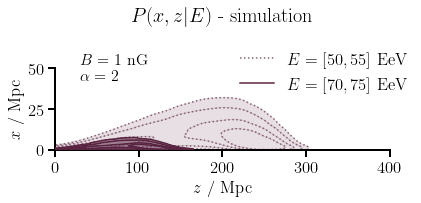

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 0.25 * 6))

# Plot
# KW: bw is deprecated for bw_adjust and bw_method, and bw_method = "scott" does the trick
# 50 - 55 EeV
sns.kdeplot(z_arr[0], x_arr[0], cmap = lp, 
            levels=levels, bw_method="scott",
            alpha = 1, linestyles = ':', linewidths = 1.5, zorder = 2)
sns.kdeplot(z_arr[0], x_arr[0], cmap = lp,
            levels=levels, bw_method="scott", fill = True, alpha = 0.2, zorder = 1)
# 70 - 75 EeV
sns.kdeplot(z_arr[1], x_arr[1], cmap = dp, 
            levels=levels, bw_method="scott", alpha = 1, linewidths = 1.5, zorder = 3)
sns.kdeplot(z_arr[1], x_arr[1], cmap = dp, levels=levels, bw_method="scott",
           fill = True, alpha = 0.5, zorder = 2)

# Annotate
ax.set_xlabel(r'$z$ / Mpc')
ax.set_ylabel(r'$x$ / Mpc')
ax.set_title(r'$P(x, z | E)$ - simulation', y = 1.5)
ax.set_xlim(0, 400)
ax.set_ylim(0, 50)
ax.text(30, 42.5, '$B = 1$ nG \n $\\alpha = 2$', fontsize = 16)
ax.legend(handles = legend_elements, bbox_to_anchor = (1.1, 1.4));

### Figure 5

Now compare the results with and without detection effects for a single selected energy range. We plot $50 - 55 \ \rm{EeV}$ here, but the procedure is exactly the same for other energy ranges. 

In [18]:
# Contour levels
levels = [0.97, 0.9, 0.6, 0.3, 0.]
levels = [1. - l for l in levels]  # as above

# Prepare legend
legend_elements = [Line2D([0], [0], color = lightblue, linestyle = '--', 
                          label = '$\hat{E}$', linewidth = 1.5),
                  Line2D([0], [0], color = darkblue, label = '$E$',linewidth = 1.5)] 

# Colourmaps
lb = ListedColormap([lightblue])
db = ListedColormap([darkblue])

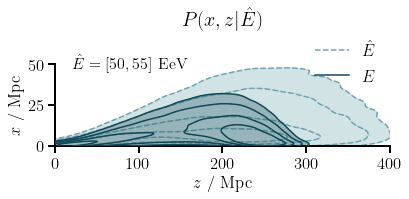

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 0.25 * 6)

# Plot
# Including detection uncertainties
sns.kdeplot(z_det[0], x_det[0], cmap = lb, bw_method="scott",
            levels=levels, alpha = 1, linestyles = '--', 
            linewidths = 1.5, zorder = 2)
sns.kdeplot(z_det[0], x_det[0], cmap = lb, bw_method="scott",
            levels=levels, shade = True, alpha = 0.3, zorder = 1)
# Ignoring detection uncertainties
sns.kdeplot(z_arr[0], x_arr[0], cmap = db, bw_method="scott",
            levels=levels, alpha = 1, linewidths = 1.5, zorder = 3)
sns.kdeplot(z_arr[0], x_arr[0], cmap = db, bw_method="scott",
            levels=levels, shade = True, alpha = 0.3, zorder = 2)


# Annotate
ax.set_xlabel(r'$z$ / Mpc')
ax.set_ylabel(r'$x$ / Mpc')
ax.set_title(r'$P(x, z |\hat{E})$', y = 1.4)
ax.set_xlim(0, 400)
ax.set_ylim(0, 50)
ax.text(20, 47.5, '$\hat{E} = [50,55]$ EeV', fontsize = 16)
ax.legend(handles = legend_elements, bbox_to_anchor = (1., 1.45));